In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [1]:
pip install -r "/content/gdrive/MyDrive/MA_XAI/CTdata/Brain_Hemorage_python/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
from torchvision import transforms, datasets, models
from torchvision.models import alexnet, AlexNet_Weights
import random
import fastprogress
import time
from datetime import date
import ast
import gc


#imports from captum library
from captum.attr import (
    IntegratedGradients,
    DeepLift,
    DeepLiftShap,
    KernelShap,
    NoiseTunnel,
    LRP,
    Lime
)
from captum.attr import visualization as viz
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper
from captum._utils.models.linear_model import SkLearnLinearModel
from captum.attr._utils.lrp_rules import EpsilonRule, Alpha1_Beta0_Rule
from captum._utils.models.linear_model import SkLearnLinearModel
from captum.attr._core.lime import get_exp_kernel_similarity_function
import plotly.express as px

import quantus


# import packages for computation of superpixels
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io




/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


Google Colab specifics

In [3]:
import sys
sys.path.append('/content/gdrive/MyDrive/')

In [4]:
import utils_MA
from utils_MA import get_device, accuracy, plot, test

Get GPUs when available

In [5]:
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla T4
8 CPUs available


Load test data

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])

loss_fn = nn.MSELoss()
batch_size = 512

# Load test ids for bounding boxes
test_ids = pd.read_csv('/content/gdrive/MyDrive/MA_XAI/CTdata/Classification_rotated/test_ids_rotated.csv')

# Load full test data set
testset = datasets.ImageFolder('/content/gdrive/MyDrive/MA_XAI/CTdata/Classification_rotated/Test/', transform=transform)

# Get val samples ------------------------------------------------------------------------------------------------
testloader = torch.utils.data.DataLoader(testset,batch_size=len(testset),shuffle=True)

In [21]:
small = list(range(16000, len(testset), 1))

testset1 = torch.utils.data.Subset(testset, small)

testloader1 = torch.utils.data.DataLoader(testset1,batch_size=512,shuffle=True)

Set up Model and load saved parameters from trained model

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000, dropout = 0) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=False),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=False),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

my_AlexNet = AlexNet()
orig_AlexNet = models.alexnet(weights = AlexNet_Weights.DEFAULT)
my_AlexNet.load_state_dict(orig_AlexNet.state_dict())

class extendedAlexNet(nn.Module):
    def __init__(self):
        super(extendedAlexNet,self).__init__()
        self.layer1 = nn.Linear(1000,100)
        self.layer2 = nn.Linear(100,1)
        self.net = my_AlexNet
        # net.features parameters are taken from AlexNet and will not be trained
        for p in self.net.features.parameters():
            p.requires_grad=False

    def forward(self,x):
        x1 = self.net(x)
        y = self.layer1(x1)
        y = self.layer2(y)
        return y


# Load saved model
path = "/content/gdrive/MyDrive/MA_XAI/CTdata/Classification/Results/Saved_Models/AlexNet_0213.pth"

# set up model
model = extendedAlexNet().to(device)

# load weights
model.load_state_dict(torch.load(path, map_location=torch.device('cpu'))) 

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
baseline_black = torch.zeros(1,3,512,512)
model(baseline_black.to(device))

tensor([[0.0073]], device='cuda:0', grad_fn=<AddmmBackward0>)

Evaluate estimated model on the test data



0.15181363193374692

0.8185200744163716

0.7019115289225117

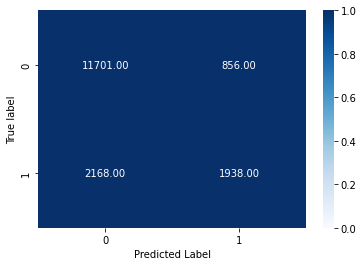

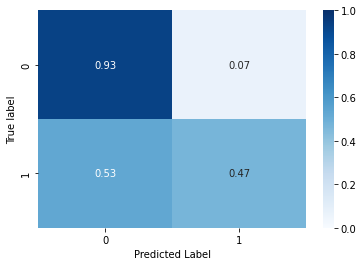

In [22]:
# Evaluate estimated model on the test data
test_loss, test_acc, test_auc, confusion_matrix, y, y_pred = test(testloader1,model,device, loss_fn)
display(test_loss, test_acc, test_auc)
confusion_matrix2 = confusion_matrix / confusion_matrix.sum(axis = 1, keepdims = True)
sb.heatmap(confusion_matrix, vmin = 0, vmax = 1, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel("True label")
plt.xlabel("Predicted Label")
plt.show()


sb.heatmap(confusion_matrix2, vmin = 0, vmax = 1, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel("True label")
plt.xlabel("Predicted Label")
plt.show()

In [10]:
""" Match bounding boxes with associated images """

# Labels of images in the testset
testset_labels = []
for s,t in testset.imgs:
  s0 = s.replace('/content/gdrive/MyDrive/MA_XAI/CTdata/Classification_rotated/Test/1Hemorrage/','')
  s1 = s0.replace('/content/gdrive/MyDrive/MA_XAI/CTdata/Classification_rotated/Test/0Not_Hemorrage/','')
  s2 = s1.replace('.jpg','')
  testset_labels.append(s2)

# Merge bounding box information and test IDs together
info_boxes0 = pd.read_csv("/content/gdrive/MyDrive/MA_XAI/CTdata/BHX/physionet.org/files/bhx-brain-bounding-box/1.1/3_Extrapolation_to_Selected_Series.csv")
info_boxes0['uniqueID'] = info_boxes0["SOPInstanceUID"] + info_boxes0["SeriesInstanceUID"] + info_boxes0["StudyInstanceUID"]
info_boxes0 = info_boxes0.loc[info_boxes0["labelType"] == "handDrawn",:]
info_boxes0 = pd.merge(test_ids, info_boxes0, on = 'uniqueID',how = 'right')
info_boxes = info_boxes0.loc[info_boxes0['label'].notnull()]
display(len(info_boxes)) # number of images with 'handDrawn' bbox information in COMPLETE testset (i only have 1/7 of the testset)


testnames_pos_list = []
for l in testset_labels:
  if 'Not' not in l:
    testnames_pos_list.append(l)
testnames_pos = pd.Series(testnames_pos_list, name = 'label')

testnames_w_box = pd.merge(testnames_pos,info_boxes, on = 'label', how = 'inner')
display(len(testnames_w_box)) #number of images in the currently used testset with available bounding box information 


# Obtain postitions of the images in the testset and the according bounding box information
idx_images0 = []
box_infos = []

for row in range(len(testnames_w_box)):
  label = testnames_w_box.iloc[row,0]
  for idx in range(len(testset_labels)):
    if label == testset_labels[idx]:
      idx_images0.append(idx)   # save index of images in the test data
      box_infos.append(testnames_w_box.iloc[row,11])
      

M_infos = []
topleft_infos = []
bottomright_infos = []

# in addition save information to get original image back
df_helper = testnames_w_box.drop_duplicates(subset='label', keep="first")   # drop all rows that are just there because of multiple bounding boxes

for row in range(len(df_helper)):
  label = df_helper.iloc[row,0]
  for idx in range(len(testset_labels)):
    if label == testset_labels[idx]:
      M_infos.append(df_helper.iloc[row,3])
      topleft_infos.append(df_helper.iloc[row,4])
      bottomright_infos.append(df_helper.iloc[row,5])



idx_images = list(dict.fromkeys(idx_images0)) 


# Create pseudo index for bounding boxes
# Boxes within the same image get the same 'index'
idx0 = []
count = 0
idx0.append(count)
for i in range(1,len(idx_images0)):
  if idx_images0[i] != idx_images0[i-1]:
    count = count+1
  idx0.append(count)



# custom function that extracts array with bounding box information from string obtained from the original csv-file
# the array is then passed to draw_bounding_boxes()

def get_bounding_box(box_string):
  boxes_l = []
  for string in box_string:
    d = ast.literal_eval(string)
    x1 = round(d['x']) 
    x2 = round(d['x'] + d['width'])
    y1 = round(d['y'])
    y2 = round(d['y'] + d['height'])
    box = torch.tensor([[x1, y1, x2, y2]],dtype=torch.int)
    b = box[0]
    boxes_l.append(b)
    
  boxes = torch.stack(boxes_l)
  return boxes

1288

1288

In [11]:
def get_arrayM(stringM):
    s = stringM
    s = s.replace('\n','')
    s = s.replace(' ','')
    s= s.replace('[array(','').replace(')]','')
    m = np.asarray(ast.literal_eval(s))
    return m

def get_coords(stringcoord):
  s = stringcoord
  s = s.replace('[array(','').replace(')]','')
  m = np.asarray(ast.literal_eval(s))
  return m


In [12]:
index_list = []
bbox_list = []
M_list = []
topleft_list = []
bottomright_list = []

for i in range(len(idx_images)):

  idx_hemorrage = i

  idx_img = idx_images[i]
  orig_img0 = testset[idx_img][0] *255
  orig_img = orig_img0.to(dtype=torch.uint8).clone().detach()
  idx_box = [int(number) for number in (np.where( np.asarray(idx0) == idx_hemorrage)[0])]
  bbox = get_bounding_box([box_infos[i] for i in idx_box])
  
  index_list.append(idx_img)
  bbox_list.append(bbox)

  M_list.append(get_arrayM(M_infos[i]))
  topleft_list.append(get_coords(topleft_infos[i]))
  bottomright_list.append(get_coords(bottomright_infos[i]))

  

# Save indeces and boxes in dictionary for later use
bbox_dict = {index_list[i]: bbox_list[i] for i in range(len(index_list))}
M_dict = {index_list[i]: M_list[i] for i in range(len(index_list))}
topleft_dict = {index_list[i]: topleft_list[i] for i in range(len(index_list))}
bottomright_dict = {index_list[i]: bottomright_list[i] for i in range(len(index_list))}        


In [13]:
def compute_superpixel_mask(image,num_segments = 500,display = False):
  im = img_as_float(torchvision.transforms.ToPILImage()(image.squeeze(0)))
  s = slic(im, n_segments = num_segments, sigma = 5)
  s = s-1 #start segments at label 0 for Captum
  

  # show the output of SLIC
  if display:
    fig = plt.figure("Superpixels -- %d segments" % (num_segments))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(im, s))
    plt.axis("off")
    # show the plots
    plt.show()

  segments = torch.tensor(s).unsqueeze(0).repeat(3, 1, 1)
  return segments


In [14]:
def bounding_box_mask(bboxes):

  """ Function to mask the pixels that are within the bounding box.
      The mask will then be used to compute the share of the attributions that are inside the bounding box """

  mask = torch.zeros((512,512))

  for bbox in bboxes:
    bbox = bbox.squeeze()
    mask[bbox[1]:(bbox[3]+1),bbox[0]:(bbox[2]+1)] = 1

  mask = np.asarray(mask)
  return np.where(mask ==1, True, False)



def calc_share_inside(attr, mask):

  """ calculate share of attributions inside the bounding box for each image
      only consider positive attributions """
  attr = attr.detach().cpu().numpy()
  attr = np.where(attr > 0,attr,0)   # only positive attributions
  
  m = torch.tensor(mask).unsqueeze(0).repeat(3, 1, 1)
  sum_inside = attr[m].sum()
  totalsum = attr.sum()

  return np.round((sum_inside / totalsum),2) 

In [15]:
def get_orig_img_back(img,M,topleft,bottomright):

  # undo padding
  img = np.uint8(img)

  cropped_height = bottomright[0] - topleft[0]
  cropped_width = bottomright[1] - topleft[1]

  take_top = (512 - cropped_height) // 2
  take_left = (512 - cropped_width) // 2

  img = img[:,take_top+1:take_top+1+cropped_height, take_left+1:take_left+1+cropped_width]
  # undo centralization of skull
  img_copy = np.pad(img, ((0,0), (topleft[0], 724 - bottomright[0] ), (topleft[1], 724 - bottomright[1] )), 'constant')
  
  # undo rotation
  # larger image was necessary such that the rotation can be recovered
  OKMM = cv2.invertAffineTransform(M)
  
  rot_channels = []
  for i in range(3): # rotate each channel on its own
    chan_rot = cv2.warpAffine(img_copy[i,:,:],OKMM,(724, 724), cv2.INTER_CUBIC)
    rot_channels.append(chan_rot)
  
  img_back = np.stack(rot_channels)
  img_back = img_back[:,106:-106, 106:-106] # crop image back to orginal size
  img_back = torch.from_numpy(img_back)


  return img_back

Verified bounding boxes with:
https://public.md.ai/annotator/project/Y2qr6vqv/workspace
 
The numbers in brackets indicate the asccociated image position on the website (Prüfung/Serie/Bild)


'../Classification_rotated/Test/1Hemorrage/Hemorrage223.jpg'
(490/1/20)


'../Classification_rotated/Test/1Hemorrage/Hemorrage217.jpg'
(490/1/16)

'../Classification_rotated/Test/1Hemorrage/Hemorrage997.jpg'
(489/1/14)

'../Classification_rotated/Test/1Hemorrage/Hemorrage1195.jpg'
(482/1/16)







In [19]:
random.seed(42)

# Small testset to compute attributions
rand_idx = random.sample(range(len(testset)), 1)
IDX = idx_images + rand_idx
IDX = np.asarray(list(dict.fromkeys(IDX)))

# Split test set into four subgroups to avoid memory issues when calculating attributions
limits = np.floor(np.linspace(0,len(IDX),6)).astype(int)

first = [testset[i] for i in IDX[:limits[1]]]
second = [testset[i] for i in IDX[limits[1]:limits[2]]]
third = [testset[i] for i in IDX[limits[2]:limits[3]]]
fourth = [testset[i] for i in IDX[limits[3]:limits[4]]]
fifth = [testset[i] for i in IDX[limits[4]:]]

Calculate Explanations for (back-rotated) Images with bounding boxes and a few negative samples (True Negatives and False Negatives) but not on the complete data.

In [19]:
IDX_group = IDX[limits[4]:]
calc_attr_testset = [testset[i] for i in IDX[limits[4]:]]
group = 'fifth'
calc_attr_dl = torch.utils.data.DataLoader(calc_attr_testset,batch_size=len(calc_attr_testset),shuffle=False)



RANDOM_SEED = 42
RANDOM = np.random.RandomState(RANDOM_SEED)

# define baselines
baseline_random = torch.rand(1,3,512,512,generator=torch.Generator().manual_seed(RANDOM_SEED)) * 255
baseline_black = torch.zeros(1,3,512,512)

LIME_ATTR, KSHAP_ATTR, LRP_ATTR, DL_ATTR, IG_ATTR = [], [], [], [], []


# compute attributions image for image (due to memory issues)
for i in range(len(IDX_group)):

    if IDX_group[i] in bbox_dict.keys():
  
      """ transform image back to original image (before cropping and rotataion) """
      M = M_dict.get(IDX_group[i])
      tl = topleft_dict.get(IDX_group[i])
      br = bottomright_dict.get(IDX_group[i])

      orig_img0 = testset[IDX_group[i]][0] *255
      img = get_orig_img_back(orig_img0,M,tl,br)
      img = torch.unsqueeze(img, dim=0).float()

    else: # I did not safe rotation information for images without boxes they should thus be ignored for the analyis
      orig_img0 = testset[IDX_group[i]][0] *255
      img = torch.unsqueeze(orig_img0, dim=0).float()

    
    """ Compute superpixels for LIME and SHAP """
    mask = compute_superpixel_mask(img)

    """ LIME """
    gc.collect()
    torch.cuda.empty_cache()
    lime = Lime(model,
                SkLearnLinearModel("linear_model.Ridge"))

    LIME_ATTR.append(lime.attribute(img.to(device), feature_mask=mask.to(device),n_samples = 100))

    """ Kernel SHAP """
    gc.collect()
    torch.cuda.empty_cache()
    kernelshap = KernelShap(model)
    KSHAP_ATTR.append(kernelshap.attribute(img.to(device), feature_mask = mask.to(device),n_samples = 100))
      
    """ LRP """
    gc.collect()
    torch.cuda.empty_cache()
    lrp = LRP(model)
    LRP_ATTR.append(lrp.attribute(img.to(device)))

    """ DeepLIFT """
    gc.collect()
    torch.cuda.empty_cache()
    dl = DeepLift(model)
    DL_ATTR.append(dl.attribute(inputs = img.to(device), baselines = baseline_black.to(device)))

    """ Integrated Gradient """
    gc.collect()
    torch.cuda.empty_cache()
    ig = IntegratedGradients(model)
    IG_ATTR.append(ig.attribute(img.to(device),n_steps=50, baselines = baseline_black.to(device)))

LIME_ATTR = torch.stack(LIME_ATTR).squeeze()
KSHAP_ATTR = torch.stack(KSHAP_ATTR).squeeze()
LRP_ATTR = torch.stack(LRP_ATTR).squeeze()
DL_ATTR = torch.stack(DL_ATTR).squeeze()
IG_ATTR = torch.stack(IG_ATTR).squeeze()                                               

# Save attributions

# Save explanations to file.
explanations = {
    "Lime": LIME_ATTR,
    "KernelShap": KSHAP_ATTR,
    "LRP": LRP_ATTR,
    "DeepLIFT": DL_ATTR,
    "IntegratedGradients": IG_ATTR
}


day = date.today().strftime("%m%d")

explanations_save_name = 'explanations_%s_%s.pkl' % (day,group)
pickle_file = F"/content/gdrive/MyDrive/MA_XAI/CTdata/Classification/Results/{explanations_save_name}"
with open(pickle_file, 'wb') as f0:
      pickle.dump(explanations, f0)


KeyboardInterrupt: ignored

In [16]:
gc.collect()
torch.cuda.empty_cache()

pickle_file = F"/content/gdrive/MyDrive/MA_XAI/CTdata/Classification/Results/explanations_0214_fifth.pkl"
with open(pickle_file, 'rb') as f0:
    attr = pickle.load(f0)

0.33494898676872253

0.6174402250351617

0.8084507042253521

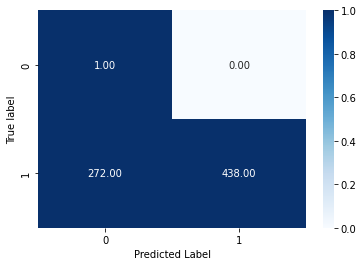

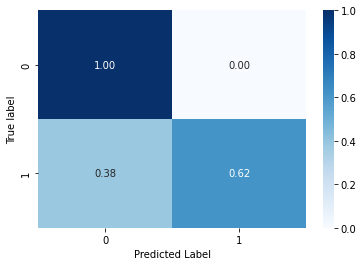

In [20]:
calc_attr_testset = [testset[i] for i in IDX]
calc_attr_dl = torch.utils.data.DataLoader(calc_attr_testset,batch_size=len(calc_attr_testset),shuffle=False)

test_loss, test_acc, test_auc, confusion_matrix, y, y_pred = test(calc_attr_dl,model,device, loss_fn)
display(test_loss, test_acc, test_auc)
confusion_matrix2 = confusion_matrix / confusion_matrix.sum(axis = 1, keepdims = True)
sb.heatmap(confusion_matrix, vmin = 0, vmax = 1, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel("True label")
plt.xlabel("Predicted Label")
plt.show()


sb.heatmap(confusion_matrix2, vmin = 0, vmax = 1, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel("True label")
plt.xlabel("Predicted Label")
plt.show()

KeyboardInterrupt: ignored

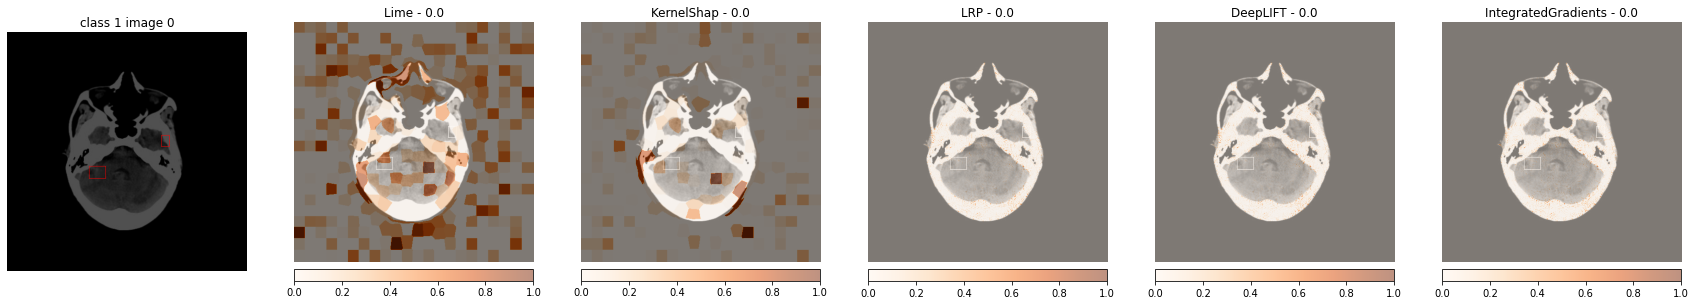

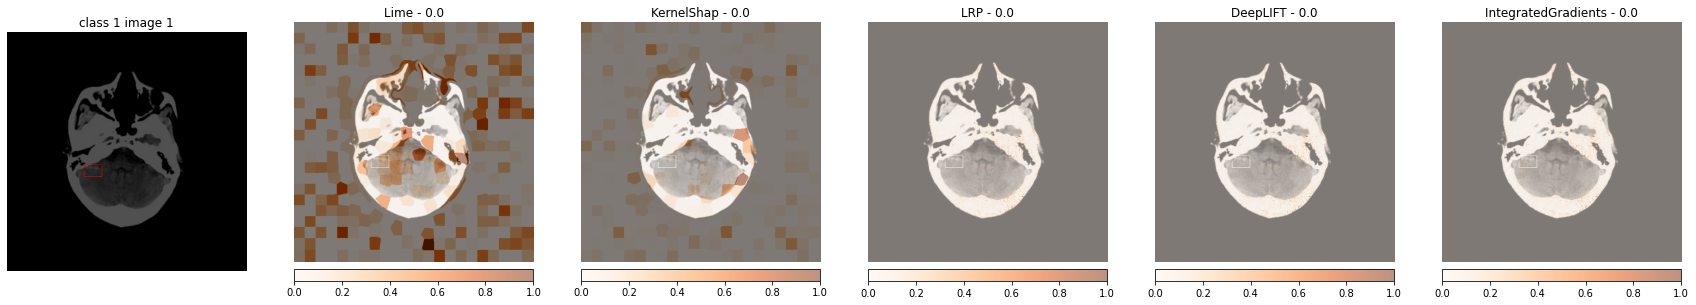

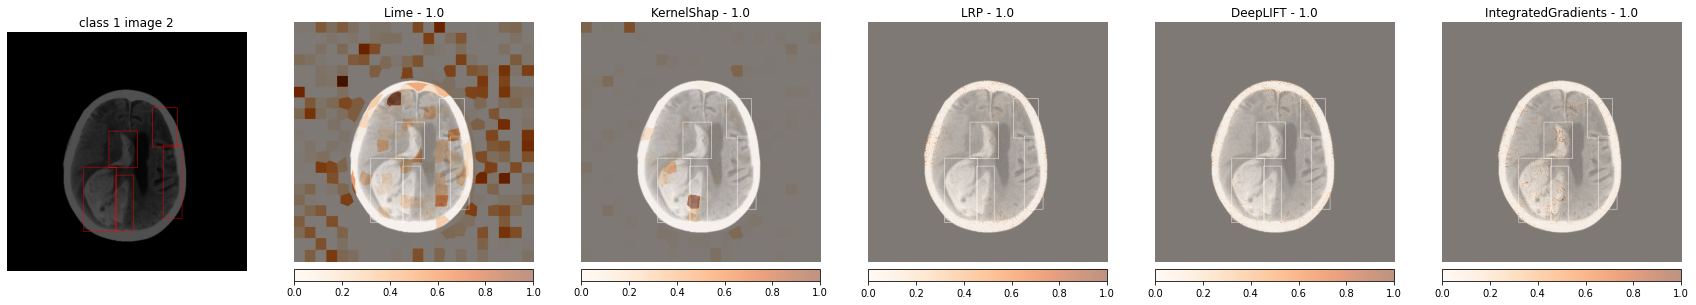

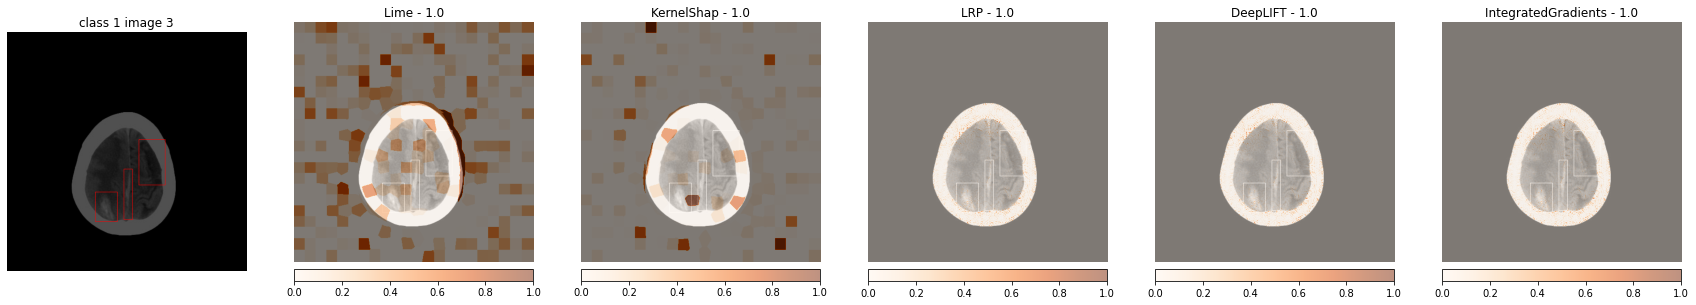

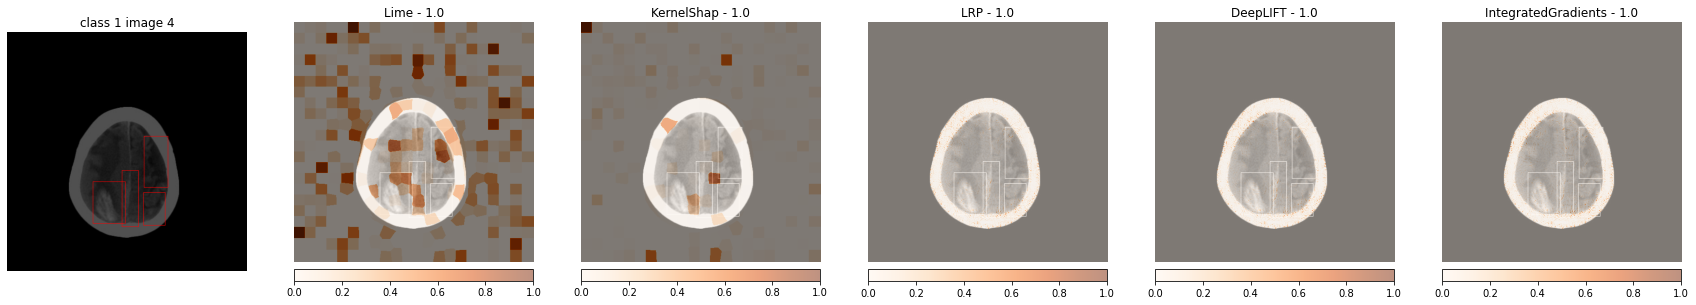

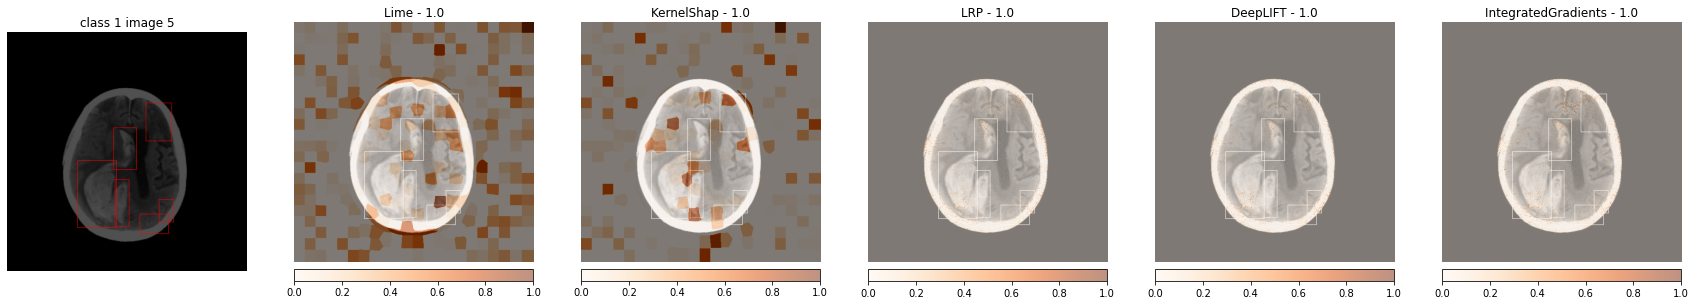

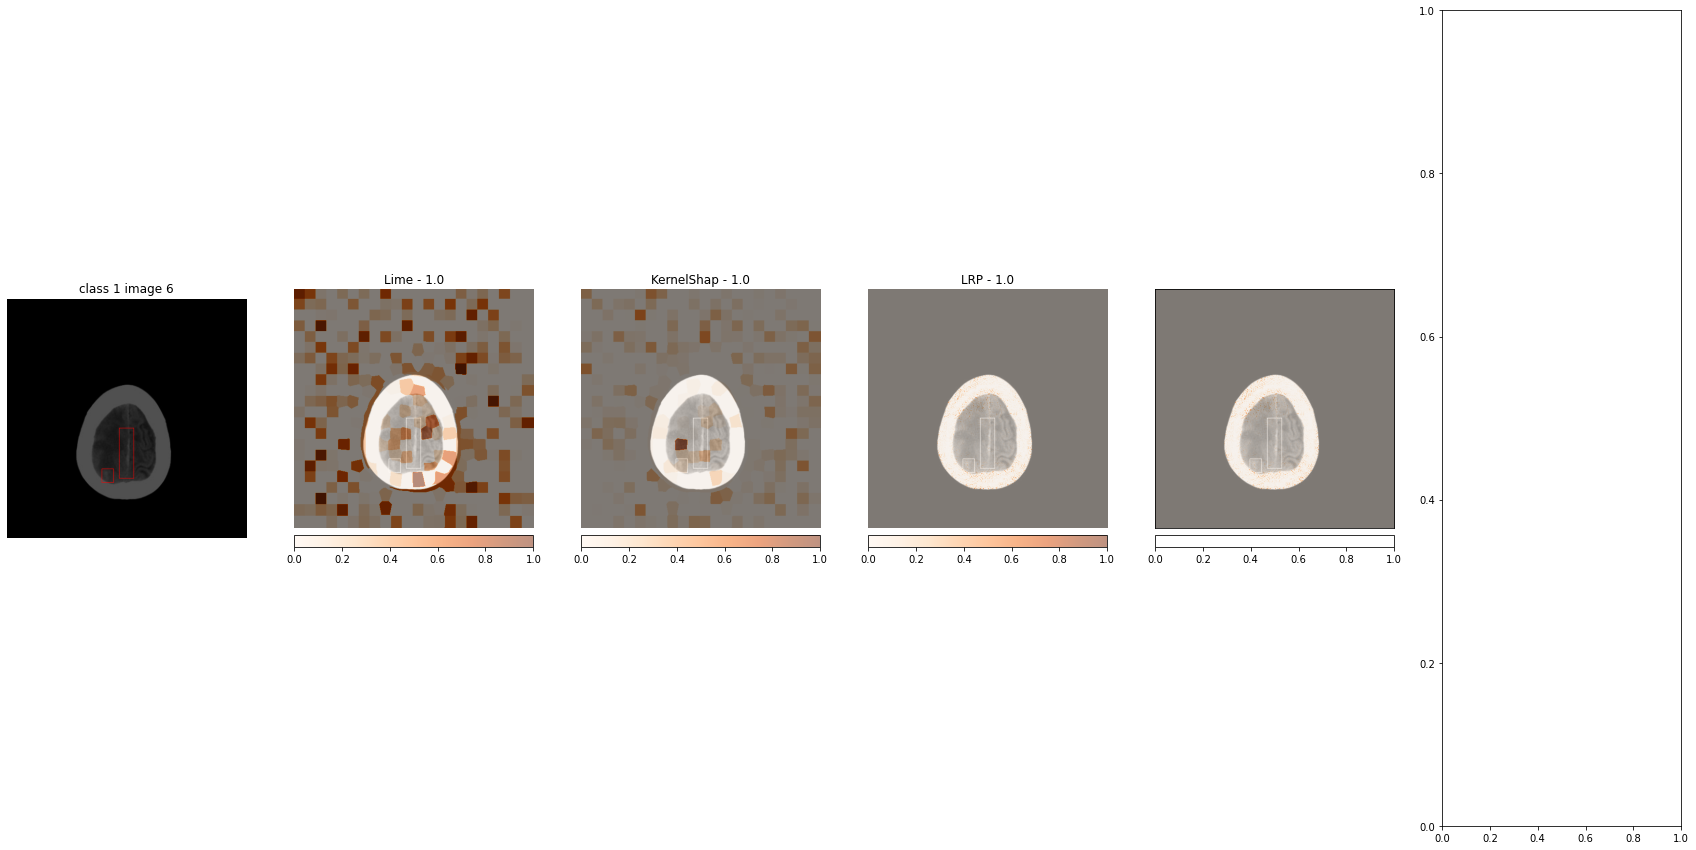

In [22]:
IDX_group = IDX[limits[4]:]
explanations = attr
SHARES = []


for i in range(len(IDX_group)):

  p = round(y_pred[i],0) # prediction - to identify TP/FP/TN/FN

  if IDX_group[i] in bbox_dict.keys():
    
    bbox = bbox_dict.get(IDX_group[i])
    M = M_dict.get(IDX_group[i])
    tl = topleft_dict.get(IDX_group[i])
    br = bottomright_dict.get(IDX_group[i])


    orig_img0 = testset[IDX_group[i]][0] *255
    orig_img = get_orig_img_back(orig_img0,M,tl,br)
    
    box_img = draw_bounding_boxes(orig_img,bbox, colors = 'red')
    # transform this image to PIL image
    box_img_plot = torchvision.transforms.ToPILImage()(box_img)

    # draw bounding boxes
    box_img = draw_bounding_boxes(orig_img,bbox, colors = 'red')
    mask = bounding_box_mask(bbox)
    

    fig, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(30, 15))
    axes[0].imshow(np.transpose(box_img.squeeze().cpu().detach().numpy(), (1,2,0)))
    axes[0].title.set_text(f"class {testset[IDX_group[i]][1]} image {i}")
    axes[0].axis("off"); 
    
    svec = []
    for j, (k, v) in enumerate(explanations.items()):
      _ = viz.visualize_image_attr(np.transpose(explanations[k][i].cpu().detach().numpy(),(1,2,0)),
                             np.transpose(box_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method="blended_heat_map",sign="positive",cmap = "Oranges",
                             show_colorbar=True, title=f"{k}", plt_fig_axis = (fig,axes[j+1]),use_pyplot = False)
      
      
      s = calc_share_inside(explanations[k][i],mask)
      svec.append(s)
      axes[j+1].title.set_text(f"{k} - {p}")
      axes[j+1].axis("off");
      
        

  else:
    orig_img0 = testset[IDX_group[i]][0] *255
    orig_img = orig_img0.to(dtype=torch.uint8).clone().detach()
    
    fig, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(20, 10))
    axes[0].imshow(np.transpose(orig_img.squeeze().cpu().detach().numpy(), (1,2,0)))
    axes[0].title.set_text(f"class {testset[IDX_group[i]][1]} image {i}")
    axes[0].axis("off"); 
    for j, (k, v) in enumerate(explanations.items()):
      svec = [None,None,None,None,None]
      _ = viz.visualize_image_attr(np.transpose(explanations[k][i].cpu().detach().numpy(),(1,2,0)),
                             np.transpose(orig_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method="heat_map",sign="positive", cmap = "Oranges",
                             show_colorbar=True, title=f"{k}", plt_fig_axis = (fig,axes[j+1]),use_pyplot = False)
      axes[j+1].title.set_text(f"{k} - {p}")
      axes[j+1].axis("off");
    
  SHARES.append(svec)


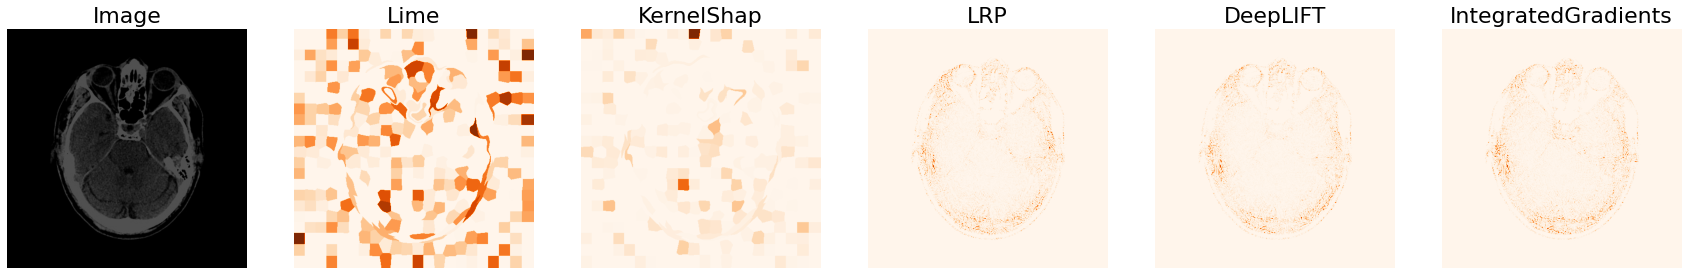

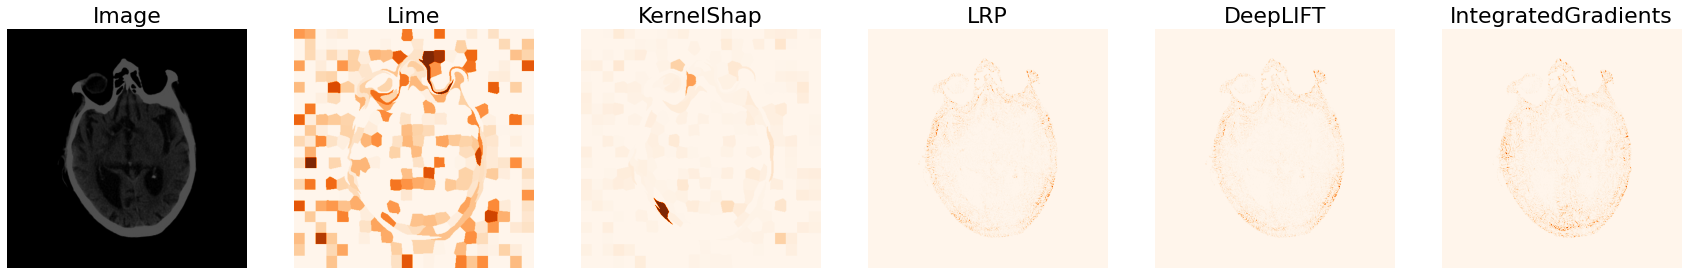

In [24]:
tn = [112,96]
fp = [89,98]

for i in fp:
    orig_img0 = testset[IDX_group[i]][0] *255
    orig_img = orig_img0.to(dtype=torch.uint8).clone().detach()
    
    fig, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(30, 20))
    axes[0].imshow(np.transpose(orig_img.squeeze().cpu().detach().numpy(), (1,2,0)))
    axes[0].set_title("Image",fontsize = 22)
    axes[0].axis("off"); 
    for j, (k, v) in enumerate(explanations.items()):
      _ = viz.visualize_image_attr(np.transpose(explanations[k][i].cpu().detach().numpy(),(1,2,0)),
                             np.transpose(orig_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method="heat_map",sign="positive", cmap = "Oranges",
                             show_colorbar=False, title=f"{k}", plt_fig_axis = (fig,axes[j+1]),use_pyplot = False)
      axes[j+1].set_title(f"{k}",fontsize = 22)
      axes[j+1].axis("off");

    plt.savefig(f'/content/gdrive/MyDrive/MA_XAI/CTdata/Classification/Results/attr_map_{i}.png',bbox_inches='tight')

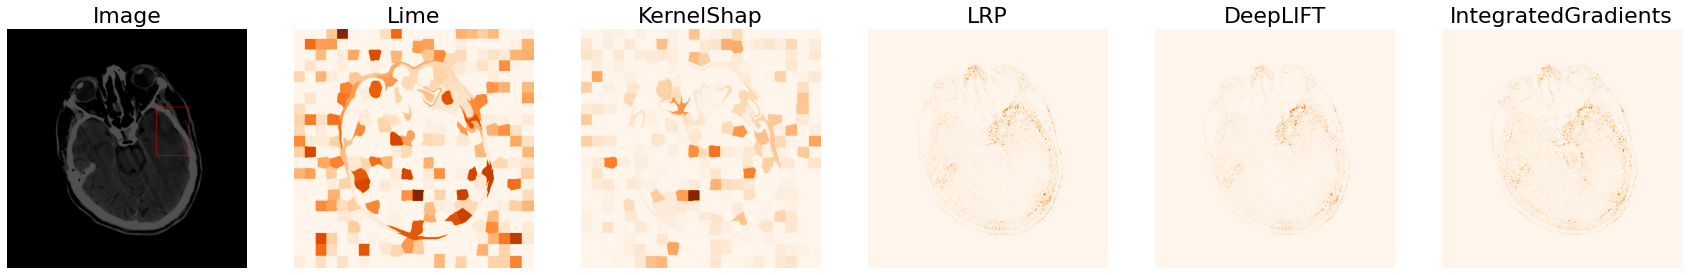

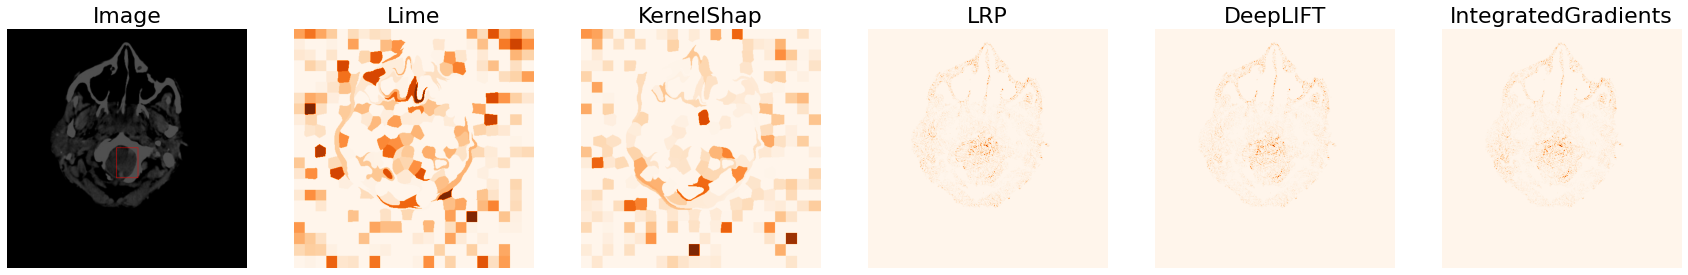

In [27]:
# Plot single images
# 

tp = [2,59,60,18]
fn = [16,40]

for i in fn:

  bbox = bbox_dict.get(IDX_group[i])
  M = M_dict.get(IDX_group[i])
  tl = topleft_dict.get(IDX_group[i])
  br = bottomright_dict.get(IDX_group[i])


  orig_img0 = testset[IDX_group[i]][0] *255
  orig_img = get_orig_img_back(orig_img0,M,tl,br)
      
  box_img = draw_bounding_boxes(orig_img,bbox, colors = 'red')
  # transform this image to PIL image
  box_img_plot = torchvision.transforms.ToPILImage()(box_img)

  # draw bounding boxes
  box_img = draw_bounding_boxes(orig_img,bbox, colors = 'red')
  mask = bounding_box_mask(bbox)

  fig, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(30, 20))
  axes[0].imshow(np.transpose(box_img.squeeze().cpu().detach().numpy(), (1,2,0)))
  axes[0].set_title("Image",fontsize = 22)
  axes[0].axis("off"); 
  for j, (k, v) in enumerate(explanations.items()):
      _ = viz.visualize_image_attr(np.transpose(explanations[k][i].cpu().detach().numpy(),(1,2,0)),
                            np.transpose(box_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                            method="heat_map",sign="positive", cmap = "Oranges", 
                            show_colorbar=False, title=f"{k}", plt_fig_axis = (fig,axes[j+1]),use_pyplot = False)
      axes[j+1].set_title(f"{k}",fontsize = 22)
      axes[j+1].axis("off");

  plt.savefig(f'/content/gdrive/MyDrive/MA_XAI/CTdata/Classification/Results/attr_map_fn{i}.png',bbox_inches='tight')